### <목표>
1. 고객이 보유한 주식별 보유기간 예측
2. AI/Big data를 이용한 서비스 아이디어 제안

### Work path
1.	좋은 피쳐를 찾기 위해 피쳐 엔지니어링 adjusted r2 score, aic bic score 사용 (train data set에서 먼저 확인)
2.	사용할 feature를 고른다 (외부 데이터)
3.	. logistic, gradient boosting, random forest, decision tree, cat boost, Neraul Networkt 중 택
4.	cross validation으로 hyperparameter tuning



In [ ]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

### <외부데이터 설명>
### finance_data.xlsx: KOSIS 국가 통계 포털을 통해 찾은 데이터로 feature 5개를 추가
https://kosis.kr/statHtml/statHtml.do?orgId=343&tblId=DT_343_2010_S0052

http://global.krx.co.kr/contents/GLB/05/0501/0501100100/GLB0501100100.jsp

http://global.krx.co.kr/main/main.jsp

https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1J17001&conn_path=l2
#### 1. 월별 업종별 PER: per_cd 
##### - PER이 낮을 수록 시가총액 대비 기업이 수익을 잘낸다.
#### 2. 월별 업종별 PBR: pbr_cd
##### - PBR이 낮을 수록 기업의 재무 건전성이 좋다 (튼튼한 기업)
#### 3. 업종별 배당 수익률%: div_yeild_cd
##### - 업종별 배당률에 따라 배당금을 받기 위해 주식보유를 오래 할 수있다고 가정
#### 4. 한국 거래소 지수: KRX 100
##### - 시가총액과 거래대금, 자기자본이익율, 부채비율, 유보율 등을 선정기준으로 삼아 선정된 종목으로 이루어진 지수 (코스피, 코스닥 대체)
#### 5. 소비자물가지수: cpi_cd
##### - 소비자 물가지수 변동에 따라 주식 같은 위험 자산이냐 안전 자산인 은행인가. 즉, 금리에 변동을 끼칠수 있다.




In [ ]:
# kosis 국가 통계 포털을 통해 per, pbr, 배당수익률 데이터 추가 (업종별, 월별 추가)
# krx100 한국 거래소 지수 (월별 추가)
cus = pd.read_csv("drive/MyDrive/open/cus_info.csv")
iem = pd.read_csv("drive/MyDrive/open/iem_info.csv")
hist = pd.read_csv("drive/MyDrive/open/stk_bnc_hist.csv")
train = pd.read_csv("drive/MyDrive/open/stk_hld_train.csv")
test = pd.read_csv("drive/MyDrive/open/stk_hld_test.csv")
submission = pd.read_csv("drive/MyDrive/open/sample_submission.csv")
# 추가 데이터
krx_per= pd.read_excel("drive/MyDrive/open/krx100.xlsx")
finance = pd.read_excel("drive/MyDrive/open/finance_data.xlsx")
# 데이터 전처리 한번에
# 내부 데이터 추가 (사용자의 매수, 매도 횟수)
grouped = hist['iem_cd'].groupby(hist['act_id'])
grouped=pd.DataFrame(grouped.count())
grouped.head(3)
grouped=grouped.rename(columns={'iem_cd': 'sb_amt'})
# grouped['sb_amt']= pd.qcut(grouped['sb_amt'], 10 , labels=[1,2,3,4,5,6,7,8,9,10])
# grouped
hist = pd.merge(hist, grouped, how = "left", on = ["act_id"])
hist.reset_index(drop = True, inplace = True)
# hist
train["hist_d"] = train["hold_d"]
train.hist_d = np.trunc(train["hist_d"])
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])# 고객정보의 계좌번호로 merge
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])# 종목 정보의 iem_cd 종목코드

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])

test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.
train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"] #종목 가격
# hist = hist.fillna(0)

In [ ]:
test_data['bse_dt']=test_data['byn_dt']
test_data.drop(["byn_dt"], axis = 1, inplace = True)

In [ ]:
test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd","bse_dt"])
test_data.reset_index(drop = True, inplace = True)


In [ ]:
train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data.reset_index(drop = True, inplace = True)

# test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
# test_data.reset_index(drop = True, inplace = True)

train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
# test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd",   "hold_d","submit_id"], axis = 1) #submit_id유지
#######finace data 추가

L_encoder = LabelEncoder()
test_data.reset_index(drop = True, inplace = True)

L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])
# test_data, train_data 모양 유지
combine =[train_data,test_data]

In [ ]:
# 월별 데이터로 추가 데이터 연결
train_data['bse_dt']=train_data['bse_dt']//100
test_data['bse_dt']=test_data['bse_dt']//100

# mrex_btp_dit_cd의 14 15 16은 각항목의 평균 per pbr 배당수익률 입력 (양이 적음)
#krx100 데이터 추가
krx_per['bse_dt']=krx_per["Date"]
krx_per.drop(["Date"], axis = 1, inplace = True)
krx_per=krx_per.rename(columns={'KRX 100': 'krx_per'})

krx_per.reset_index(drop = True, inplace = True)

train_data = pd.merge(train_data, krx_per, how = "left", on = ["bse_dt"])
test_data = pd.merge(test_data, krx_per, how = "left", on = ["bse_dt"])

# per, pbr, 주식 배당수익률 추가
train_data= pd.merge(train_data, finance, how = 'left', on =["mrz_btp_dit_cd","bse_dt"])
test_data= pd.merge(test_data, finance, how = 'left', on =["mrz_btp_dit_cd","bse_dt"])

# 그래프를 통해 무의미한 데이터 제거 (주거래 상품군)
train_data.drop(["mrz_pdt_tp_sgm_cd","btp_cfc_cd","bnc_qty", 'stk_par_pr'], axis = 1, inplace = True)
train_data.reset_index(drop = True, inplace = True)
test_data.drop(["mrz_pdt_tp_sgm_cd","btp_cfc_cd","bnc_qty", 'stk_par_pr'], axis = 1, inplace = True)
# bse_dt
test_data.reset_index(drop = True, inplace = True)

In [ ]:
#날짜 데이터 월별로 분류
train_list=list(train_data['bse_dt'].drop_duplicates())
train_list.sort()
len(train_list)
matching=[x for x in range(1,61)]

In [ ]:
#날짜에 따라 다를 수 있으므로 분류
for i in range(len(train_data['bse_dt'])):
  for k in range(60):
    if train_data['bse_dt'][i]==train_list[k]:
      train_data['bse_dt'][i]=matching[k]
train_data['bse_dt']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0         31.0
1         25.0
2         29.0
3         59.0
4         33.0
          ... 
281071    57.0
281072    24.0
281073    56.0
281074    53.0
281075     1.0
Name: bse_dt, Length: 281076, dtype: float64

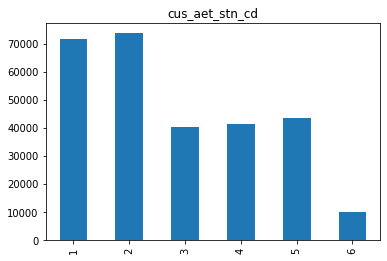

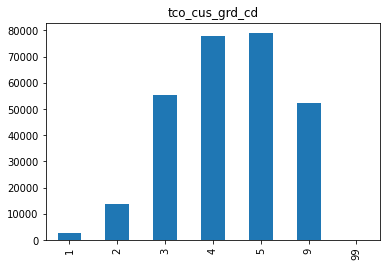

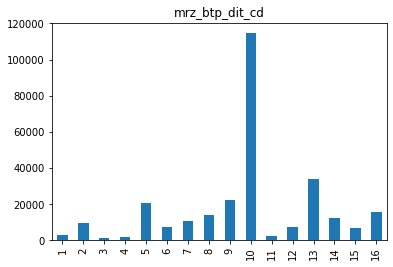

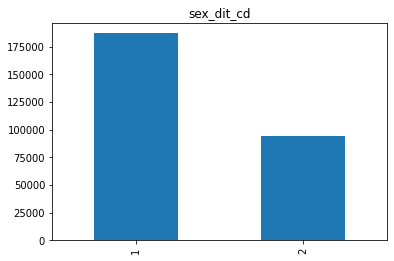

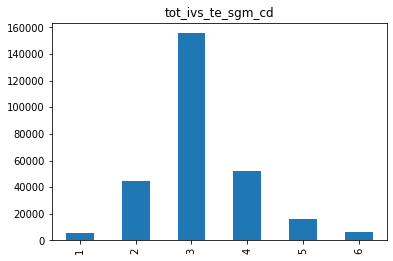

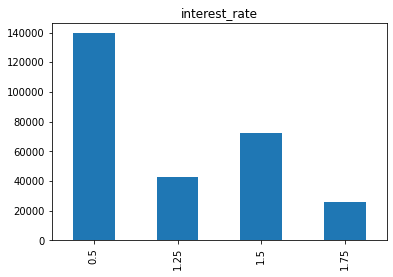

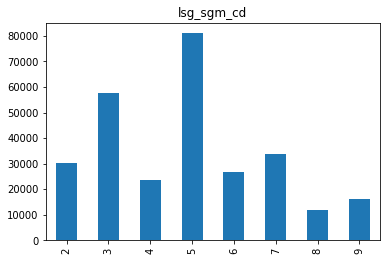

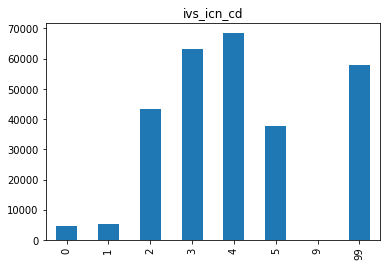

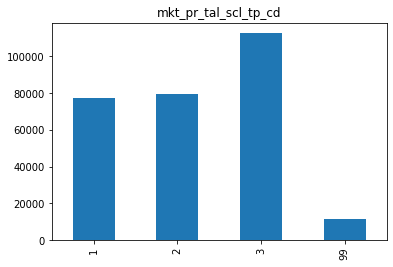

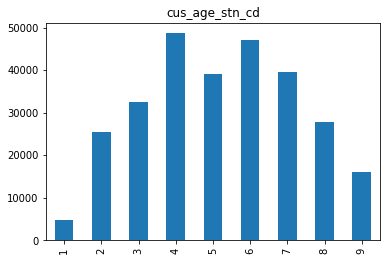

In [ ]:
# 우선 그래프로 확인
categorical_feature= list(set(train_data.columns)-set(['cpi_cd','krx_per','sb_amt', 'bnc_qty','btp_cfc_cd','iem_krl_nm','stk_p','stk_par_pr','stk_dit_cd','tot_aet_amt', 'hist_d','div_yeild_cd', 'pbr_cd', 'per_cd','bse_dt', 'KRX 100']))
for col in categorical_feature: 
  train_data[col].value_counts().sort_index().plot(kind='bar', sort_columns=False) 
  plt.title(col) 
  plt.show()
  

In [ ]:
# 자산구간에 따른 평균 주식 보유일/ 자산이 많을 수록 기간이 상대적으로 길다
print(train_data[['cus_aet_stn_cd', 'hist_d']].groupby(['cus_aet_stn_cd'], as_index=False).mean().sort_values(by='hist_d', ascending=False))
# 시가총액: 대형주의 경우 좀더 길어보임
print(train_data[['mkt_pr_tal_scl_tp_cd', 'hist_d']].groupby(['mkt_pr_tal_scl_tp_cd'], as_index=False).mean().sort_values(by='mkt_pr_tal_scl_tp_cd', ascending=True))
# 총투자기간 대비 주식 보유기간/대체로 증가한다.
print(train_data[['tot_ivs_te_sgm_cd', 'hist_d']].groupby(['tot_ivs_te_sgm_cd'], as_index=False).mean().sort_values(by='tot_ivs_te_sgm_cd', ascending=True))
# 주거래 d업종 / 큰 차이가 있다!!! 철강, 제조
print(train_data[['mrz_btp_dit_cd', 'hist_d']].groupby(['mrz_btp_dit_cd'], as_index=False).mean().sort_values(by='mrz_btp_dit_cd', ascending=True))
#life stage
print(train_data[['lsg_sgm_cd', 'hist_d']].groupby(['lsg_sgm_cd'], as_index=False).mean().sort_values(by='lsg_sgm_cd', ascending=True))
# 금리가 높을 수록 더 오래 가지고 있다.
print(train_data[['interest_rate', 'hist_d']].groupby(['interest_rate'], as_index=False).mean().sort_values(by='interest_rate', ascending=True))


   cus_aet_stn_cd     hist_d
4               5  28.645790
5               6  28.171641
3               4  20.799134
1               2  18.641326
2               3  18.356895
0               1  16.487154
   mkt_pr_tal_scl_tp_cd     hist_d
0                     1  22.563102
1                     2  18.589118
2                     3  19.477804
3                    99  24.086198
   tot_ivs_te_sgm_cd     hist_d
0                  1  14.310200
1                  2  12.965946
2                  3  21.216132
3                  4  23.018212
4                  5  20.262831
5                  6  31.490992
    mrz_btp_dit_cd     hist_d
0                1  21.675147
1                2  26.575314
2                3  10.854767
3                4  15.520000
4                5  20.188122
5                6  23.829570
6                7  20.460738
7                8  21.796417
8                9  23.226718
9               10  14.356865
10              11  22.136386
11              12  22.250879
12      

범주형 데이터를 수치형 데이터로 'hist_d'의 평균으로 기준
 

In [ ]:
#train_data
cus_aet_stn_cd_t=train_data.groupby('cus_aet_stn_cd').hist_d.mean().sort_values().reset_index(name = 'asset_n').sort_values(by = 'asset_n')
cus_age_stn_cd_t=train_data.groupby('cus_age_stn_cd').hist_d.mean().sort_values().reset_index(name = 'age_n').sort_values(by = 'age_n')
lsg_sgm_cd_t=train_data.groupby('lsg_sgm_cd').hist_d.mean().sort_values().reset_index(name = 'life_n').sort_values(by = 'life_n')
mrz_btp_dit_cd_t=train_data.groupby('mrz_btp_dit_cd').hist_d.mean().sort_values().reset_index(name = 'sector_n').sort_values(by = 'sector_n')
tot_ivs_te_sgm_cd_t=train_data.groupby('tot_ivs_te_sgm_cd').hist_d.mean().sort_values().reset_index(name = 'investing_time_n').sort_values(by = 'investing_time_n')
mkt_pr_tal_scl_tp_cd_t=train_data.groupby('mkt_pr_tal_scl_tp_cd').hist_d.mean().sort_values().reset_index(name = 'mrkcap_n').sort_values(by = 'mrkcap_n')
ivs_icn_cd_t=train_data.groupby('ivs_icn_cd').hist_d.mean().sort_values().reset_index(name = 'ivst_style_n').sort_values(by = 'ivst_style_n')
stk_dit_cd_t=train_data.groupby('stk_dit_cd').hist_d.mean().sort_values().reset_index(name = 'market_div_n').sort_values(by = 'market_div_n')
tco_cus_grd_cd_t=train_data.groupby('tco_cus_grd_cd').hist_d.mean().sort_values().reset_index(name = 'service_n').sort_values(by = 'service_n')

#test_data
cus_aet_stn_cd_test=test_data.groupby('cus_aet_stn_cd').hist_d.mean().sort_values().reset_index(name = 'asset_n').sort_values(by = 'asset_n')
cus_age_stn_cd_test=test_data.groupby('cus_age_stn_cd').hist_d.mean().sort_values().reset_index(name = 'age_n').sort_values(by = 'age_n')
lsg_sgm_cd_test=test_data.groupby('lsg_sgm_cd').hist_d.mean().sort_values().reset_index(name = 'life_n').sort_values(by = 'life_n')
mrz_btp_dit_cd_test=test_data.groupby('mrz_btp_dit_cd').hist_d.mean().sort_values().reset_index(name = 'sector_n').sort_values(by = 'sector_n')
tot_ivs_te_sgm_cd_test=test_data.groupby('tot_ivs_te_sgm_cd').hist_d.mean().sort_values().reset_index(name = 'investing_time_n').sort_values(by = 'investing_time_n')
mkt_pr_tal_scl_tp_cd_test=test_data.groupby('mkt_pr_tal_scl_tp_cd').hist_d.mean().sort_values().reset_index(name = 'mrkcap_n').sort_values(by = 'mrkcap_n')
ivs_icn_cd_test=test_data.groupby('ivs_icn_cd').hist_d.mean().sort_values().reset_index(name = 'ivst_style_n').sort_values(by = 'ivst_style_n')
# sex_dit_cd_t=train_data.groupby('sex_dit_cd').hist_d.mean().sort_values().reset_index(name = 'sex_n').sort_values(by = 'sex_n')
stk_dit_cd_test=test_data.groupby('stk_dit_cd').hist_d.mean().sort_values().reset_index(name = 'market_div_n').sort_values(by = 'market_div_n')
tco_cus_grd_cd_test=test_data.groupby('tco_cus_grd_cd').hist_d.mean().sort_values().reset_index(name = 'service_n').sort_values(by = 'service_n')
# train_data= pd.get_dummies(columns=['sex_dit_cd'], data= train_data)

In [ ]:
cat_num=[cus_aet_stn_cd_t,	cus_age_stn_cd_t,	ivs_icn_cd_t,		lsg_sgm_cd_t,	tco_cus_grd_cd_t,	tot_ivs_te_sgm_cd_t,
         mrz_btp_dit_cd_t,	mkt_pr_tal_scl_tp_cd_t,	stk_dit_cd_t]
cat_num_test=[cus_aet_stn_cd_test,	cus_age_stn_cd_test,	ivs_icn_cd_test,		lsg_sgm_cd_test,	tco_cus_grd_cd_test,	tot_ivs_te_sgm_cd_test,
         mrz_btp_dit_cd_test,	mkt_pr_tal_scl_tp_cd_test,	stk_dit_cd_test]         
        #  , sex_dit_cd_t
cat_num_col=['cus_aet_stn_cd',	'cus_age_stn_cd',	'ivs_icn_cd',		'lsg_sgm_cd',	'tco_cus_grd_cd',	'tot_ivs_te_sgm_cd',
         'mrz_btp_dit_cd',	'mkt_pr_tal_scl_tp_cd',	'stk_dit_cd']
# ,	'sex_dit_cd'
m=[cat_num,cat_num_col]
for i in range(len(cat_num)):
  train_data= pd.merge(train_data, cat_num[i], how= 'left', on=[cat_num_col[i]] )
  train_data.drop([cat_num_col[i]], axis = 1, inplace = True)

for i in range(len(cat_num_test)):
  test_data= pd.merge(test_data, cat_num[i], how= 'left', on=[cat_num_col[i]] )
  test_data.drop([cat_num_col[i]], axis = 1, inplace = True)
train_data

,hist_d,sex_dit_cd,iem_krl_nm,bse_dt,tot_aet_amt,sb_amt,stk_p,krx_per,per_cd,pbr_cd,div_yeild_cd,interest_rate,cpi_cd,asset_n,age_n,ivst_style_n,life_n,service_n,investing_time_n,sector_n,mrkcap_n,market_div_n
0,11.0,1,101,31.0,11782000.0,277.0,43000.0,10.11,97.90,5.21,0.18,1.75,103.93,18.641326,17.068113,17.49833,17.074207,16.981935,20.262831,21.796417,22.563102,24.889024
1,80.0,1,1361,25.0,4990000.0,277.0,2495000.0,12.15,258.22,4.41,0.21,1.75,103.42,18.641326,17.068113,17.49833,17.074207,16.981935,20.262831,21.796417,22.563102,24.889024
2,5.0,1,2530,29.0,14619600.0,277.0,18600.0,10.56,109.36,5.60,0.16,1.75,104.34,18.641326,17.068113,17.49833,17.074207,16.981935,20.262831,21.796417,18.589118,19.194397
3,22.0,1,1968,59.0,462000.0,277.0,7700.0,27.61,105.64,7.19,0.11,0.50,105.50,18.641326,17.068113,17.49833,17.074207,16.981935,20.262831,21.796417,18.589118,24.889024
4,324.0,1,1696,33.0,8125200.0,277.0,44400.0,9.65,121.16,6.18,0.15,1.50,105.65,18.641326,17.068113,17.49833,17.074207,16.981935,20.262831,21.796417,19.477804,19.194397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281071,7.0,1,1354,57.0,320500.0,1363.0,64100.0,24.82,8.04,0.42,4.21,0.50,106.20,28.645790,22.281656,23.13828,21.254735,24.752581,20.262831,26.575314,22.563102,24.889024
281072,17.0,1,412,24.0,89400.0,1363.0,29800.0,11.78,10.64,0.83,1.79,1.75,102.99,28.645790,22.281656,23.13828,21.254735,24.752581,20.262831,26.575314,22.563102,24.889024
281073,1.0,1,1351,56.0,221000.0,1363.0,110500.0,21.15,7.90,0.44,4.12,0.50,105.50,28.645790,22.281656,23.13828,21.254735,24.752581,20.262831,26.575314,22.563102,24.889024
281074,2.0,1,1351,53.0,99200.0,1363.0,99200.0,16.48,6.67,0.41,4.44,0.50,104.71,28.645790,22.281656,23.13828,21.254735,24.752581,20.262831,26.575314,22.563102,24.889024


In [ ]:
print("Find most important features relative to target")
corr = train_data.corr()
corr.sort_values(["hist_d"], ascending = False, inplace = True)
print(corr.hist_d)

Find most important features relative to target
hist_d              1.000000
ivst_style_n        0.159424
interest_rate       0.136517
tot_aet_amt         0.112077
service_n           0.081262
asset_n             0.077369
mrkcap_n            0.067319
life_n              0.065956
sb_amt              0.061608
stk_p               0.055538
cpi_cd              0.040567
age_n               0.039808
sex_dit_cd          0.033757
pbr_cd              0.003755
div_yeild_cd       -0.020485
iem_krl_nm         -0.021219
sector_n           -0.033271
per_cd             -0.071308
investing_time_n   -0.082693
bse_dt             -0.125793
krx_per            -0.136364
market_div_n       -0.162641
Name: hist_d, dtype: float64


In [ ]:
# 수치를 비슷하게 맞춰주기 위해 실행 (한번만 실행)
# train_data['div_yeild_cd']=train_data['div_yeild_cd']*100
# train_data['interest_rate']=train_data['interest_rate']*10
# train_data['pbr_cd']=train_data['pbr_cd']*10
# train_data['sb_amt']=train_data['sb_amt']/100
# train_data['cpi_cd']=train_data['cpi_cd']/10
# ,'sex_n'
train_data1=train_data
train_data[['bse_dt','hist_d','pbr_cd','per_cd','krx_per','div_yeild_cd', 'interest_rate','tot_aet_amt','stk_p', 'sb_amt','cpi_cd','asset_n','age_n','ivst_style_n','life_n','service_n','investing_time_n','sector_n','mrkcap_n','market_div_n']]\
=np.log1p(train_data[['bse_dt','hist_d','pbr_cd','per_cd','krx_per','div_yeild_cd', 'interest_rate','asset_n','age_n','ivst_style_n','life_n','service_n','investing_time_n','sector_n','mrkcap_n','market_div_n','cpi_cd','tot_aet_amt','stk_p', 'sb_amt']])


# test_data
# test_data['div_yeild_cd']=test_data['div_yeild_cd']*10
# test_data['interest_rate']=test_data['interest_rate']*10
# test_data['pbr_cd']=test_data['pbr_cd']*10
# test_data['sb_amt']=test_data['sb_amt']/100
# test_data['cpi_cd']=test_data['cpi_cd']/10
# ,'sex_n'
test_data[['bse_dt','pbr_cd','per_cd','krx_per','hist_d','div_yeild_cd', 'interest_rate','tot_aet_amt','stk_p', 'sb_amt','cpi_cd','asset_n','age_n','ivst_style_n','life_n','service_n','investing_time_n','sector_n','mrkcap_n','market_div_n']]\
=np.log1p(test_data[['bse_dt','pbr_cd','per_cd','krx_per','hist_d','div_yeild_cd', 'interest_rate','asset_n','age_n','ivst_style_n','life_n','service_n','investing_time_n','sector_n','mrkcap_n','market_div_n','cpi_cd','tot_aet_amt','stk_p', 'sb_amt']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


In [ ]:
test_data

,hist_d,sex_dit_cd,iem_krl_nm,bse_dt,tot_aet_amt,sb_amt,stk_p,krx_per,per_cd,pbr_cd,div_yeild_cd,interest_rate,cpi_cd,asset_n,age_n,ivst_style_n,life_n,service_n,investing_time_n,sector_n,mrkcap_n,market_div_n
0,5.036953,1,417,12.216053,2.977636,2.917680,2.894149,2.861057,4.636281,1.814825,0.157004,0.405465,2.894486,2.889368,3.056961,3.126603,3.159682,3.253819,4.660699,15.187960,9.484253,5.627621
1,5.817111,1,2231,12.215572,2.977636,2.917680,2.894149,2.386007,4.082778,1.474763,0.239017,0.916291,2.894486,2.889368,3.056961,3.126603,3.019342,3.005405,4.661645,14.741554,9.453365,5.627621
2,4.941642,1,1514,12.216058,2.977636,2.917680,2.894149,3.011606,4.690155,2.000128,0.122218,0.405465,2.894486,2.889368,3.056961,3.126603,2.974974,3.005405,4.662212,15.272217,10.344995,5.627621
3,5.468060,1,2681,12.216033,2.977636,2.917680,2.894149,2.789937,4.422328,1.646734,0.190620,0.810930,2.894486,2.889368,3.056961,3.126603,3.019342,3.005405,4.670864,15.720111,7.723562,5.627621
4,2.302585,1,2450,12.216087,2.977636,2.917680,2.894149,3.349202,4.605270,2.115050,0.104360,0.405465,2.894486,2.889368,3.056961,3.126603,3.159682,2.944450,4.669740,13.048719,10.746153,5.627621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,3.178054,1,1369,12.216082,3.389320,3.183799,3.147666,3.353756,2.306577,0.385262,1.556037,0.405465,3.102555,3.248535,3.056961,3.316921,3.159682,3.253819,4.668145,12.198549,12.198549,7.218177
70592,4.644391,1,443,12.216063,3.389320,3.183799,3.147666,3.071303,2.136531,0.350657,1.678964,0.405465,3.102555,3.248535,3.056961,3.316921,3.222318,3.005405,4.662117,12.826652,8.914761,7.218177
70593,6.755769,1,1279,12.214576,2.977636,3.018262,3.078918,2.647592,5.228378,1.396245,0.277632,0.810930,2.993806,3.025779,3.100819,3.126603,3.019342,3.005405,4.642273,NaN,NaN,NaN
70594,2.484907,1,2374,12.216087,2.977636,3.018262,3.078918,3.349202,4.605270,2.115050,0.104360,0.405465,2.993806,3.025779,3.100819,3.126603,2.974974,3.005405,4.669740,NaN,NaN,NaN


Scaler 사용
- MinMax

In [ ]:
# # standardscaler
# from sklearn.preprocessing import StandardScaler

# # 변형 객체 생성
# std_scaler = StandardScaler()

# train_data_hist=train_data['hist_d']
# train_data = train_data.drop('hist_d', axis=1)
# test_data = test_data['hist_d']
# # 훈련데이터의 모수 분포 저장
# std_scaler.fit(train_data)

# # 훈련 데이터 스케일링
# X_train_scaled = std_scaler.transform(train_data)

# # 테스트 데이터의 스케일링
# # X_test_scaled = std_scaler.transform(test_data)

# # 스케일링 된 결과 값으로 본래 값을 구할 수도 있다.
# # X_origin = std_scaler.inverse_transform(X_train_scaled)
# X_train_scaled=pd.DataFrame(columns=[train_data.columns], data=X_train_scaled )
# X_train_scaled['hist_d']=train_data_hist
# X_train_scaled

## Feature Engineering & Initial Modeling

### 관계가 5% 이상 유의미한 feature만 추출

### <Feature 사용 방안 초안>
1. 투자성향 따로 분류 그렇게 분류한 그룹별 모델 돌리기
2. 자산구간 따로 분류 그렇게 분류한 그룹별 모델 돌리기
3. Life stage 연령별 투자 성향을 알아보고 insight를 얻어 진행
4. 총 투자기간에 따라 분류 (코로나 전 후로 어떻게 되었는가)
5. 투자 성향에 따른 자산구간
- 각각에 맞는 모델을 만든후 의미가 있으면 그 의미에 맞게 고객 맵핑
- 위 내용에 주거래업종 구분을 통해 분산투자를 통한 위험성 감소를 고려하여 추천 시스템



In [ ]:
# corelation 확인
df_all_corr = train_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'hist_d']
#pbr, tot_aet_amt 의미가 없다, 

,Feature 1,Feature 2,Correlation Coefficient
21,hist_d,hist_d,1.000000
93,hist_d,market_div_n,0.162641
94,hist_d,ivst_style_n,0.159424
109,hist_d,interest_rate,0.136517
110,hist_d,krx_per,0.136364
119,hist_d,bse_dt,0.125793
127,hist_d,tot_aet_amt,0.112077
182,hist_d,investing_time_n,0.082693
185,hist_d,service_n,0.081262
194,hist_d,asset_n,0.077369


Index(['hist_d', 'bse_dt', 'tot_aet_amt', 'krx_per', 'interest_rate',
       'ivst_style_n', 'market_div_n'],
      dtype='object')


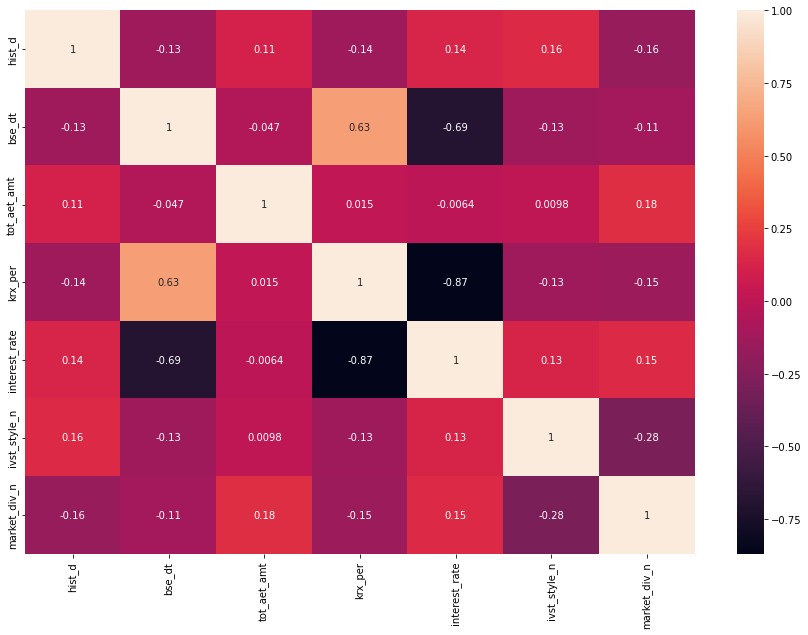

In [ ]:
cor = train_data.corr()
top_feature = cor.index[abs(cor['hist_d']) >= 0.1]
print(top_feature)
top_corr = train_data[top_feature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(top_corr, annot=True)
plt.xticks(rotation=90)
plt.show()

In [ ]:
new_df=train_data[top_feature]
new_test_df=test_data[top_feature]
new_df

,hist_d,bse_dt,tot_aet_amt,krx_per,interest_rate,ivst_style_n,market_div_n
0,2.484907,3.465736,2.977636,2.407846,1.011601,3.126603,5.627621
1,4.394449,3.258097,2.977636,2.576422,1.011601,3.126603,5.627621
2,1.791759,3.401197,2.977636,2.447551,1.011601,3.126603,5.627621
3,3.135494,4.094345,2.977636,3.353756,0.405465,3.126603,5.627621
4,5.783825,3.526361,2.977636,2.365560,0.916291,3.126603,5.627621
...,...,...,...,...,...,...,...
281071,2.079442,4.060443,3.389320,3.251149,0.405465,3.316921,7.218177
281072,2.890372,3.218876,3.389320,2.547881,1.011601,3.316921,7.218177
281073,0.693147,4.043051,3.389320,3.097837,0.405465,3.316921,7.218177
281074,1.098612,3.988984,3.389320,2.861057,0.405465,3.316921,7.218177


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


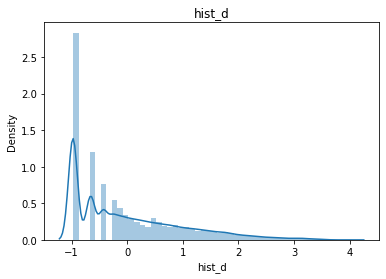

In [ ]:
#종속변수 체크
sns.distplot(train_data['hist_d'])
plt.title("hist_d")
plt.show()

## <수치를 통해 유추한 feature>

### - 자산구간에 따른 평균 주식 보유일/ 자산이 많을 수록 기간이 상대적으로 길다

### -  대형주의 경우 좀더 길어보임

### - 잔고금액에 따른 주식 보유길이

### - 총투자기간 대비 주식 보유기간/대체로 증가한다.

### - 주거래 업종 / 큰 차이가 있다!!! 철강, 제조

### - 금리가 높을 수록 더 오래 가지고 있다.

## 데이터의 Feature 확인
- adjusted r2 score, aic bic score 


In [ ]:
#딥러닝 라이브러리로, scikit-learn(사이킷런)을 이용합니다.
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,roc_curve, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [ ]:
X = new_df.drop('hist_d', axis=1)
y = new_df['hist_d']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_test1,y_test1, test_size = 0.5, random_state=42)


In [ ]:
test_x = new_test_df.drop('hist_d', axis=1)
test_y = new_test_df['hist_d']
test_x=test_x.fillna(test_x.mean())
test_y=test_y.fillna(test_y.mean())

RandomForestRegressor


In [ ]:
#50대 50
# rf = RandomForestRegressor(random_state = 518)
rf = RandomForestRegressor(n_estimators=150, 
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10)
rmse_list = []
rf_pred = np.zeros((X_train.shape[0]))
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
arr=[]
# for k in [30, 50, 100, 150, 200]:
for tr_idx, val_idx in kf.split(X_train, y_train) :
    rf = RandomForestRegressor(n_estimators = 150,random_state = 518)
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(X_test)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    rf_pred += (sub_pred / 10)
# print('version', k)
print(rf.score(X_train, y_train)) # train R2 score를 출력합니다.
print(rf.score(X_test, y_test)) # test R2 score를 출력합니다

0.5758480979390614
0.21392917037747916


In [ ]:
#@title
# numeric_cols = train_data.select_dtypes(exclude='object').columns

# skew_limit = 0.5
# skew_vals = train_data[numeric_cols].skew()

# skew_cols = (skew_vals
#              .sort_values(ascending=False)
#              .to_frame()
#              .rename(columns={0:'Skew'})
#              .query('abs(Skew) > {0}'.format(skew_limit)))

# skew_cols

데이터들을 log-log 모형에서 해석 했음
e^corr 이렇게 해석

In [ ]:
rf_mse=np.mean(rmse_list)
rf_mse

10.69044396050795

In [ ]:
y_test

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
rf_back_test  = np.e**y_test
rf_back_pred=rf_pred
compare_rf={'y_test':rf_back_test, 'y_predicted':rf_back_pred}
compare_rf=pd.DataFrame(compare_rf)
compare_rf

,y_test,y_predicted
249387,23.0,9.923666
1110,3.0,6.814054
128473,579.0,19.995138
205206,62.0,11.890586
9140,25.0,3.619467
...,...,...
168180,5.0,2.468583
249728,29.0,15.285820
143675,2.0,2.413419
33345,228.0,220.849182


In [ ]:
# predict
rf_predict =rf.predict(test_x)
predicted_rf=np.e**rf_predict
sub_rf=predicted_rf-test_y

XGBRegressor


In [ ]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
rmse_list = []
# xgb = XGBRegressor(random_state = 518)
xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

xgb_pred = np.zeros((X_train.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(X_test)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred  += (sub_pred / 10)

In [ ]:
# print(np.mean(rmse_list))
print(xgb.score(X_train, y_train)) # train R2 score를 출력합니다.
print(xgb.score(X_test, y_test)) # test R2 score를 출력합니다

In [ ]:
xgb_back  = np.e**y_test

y_compare_xgb={'y_test':xgb_back, 'y_predicted':xgb_pred}
y_compare_xgb=pd.DataFrame(y_compare_xgb)
y_compare_xgb

,y_test,y_predicted
249387,23.0,7.562347
1110,3.0,4.968951
128473,579.0,15.289624
205206,62.0,4.765376
9140,25.0,4.590550
...,...,...
168180,5.0,3.487321
249728,29.0,15.182684
143675,2.0,5.121441
33345,228.0,40.524295


In [ ]:
xgb_rmse=np.mean(rmse_list)
xgb_rmse

11.056244390431504

In [ ]:
# predict xgb
xgb_predict =rf.predict(test_x)
predicted_rf=np.e**xgb_predict
sub_xgb=predicted_rf-test_y

LGMBRegressor


In [ ]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)
rmse_list = []
models = []

model = LGBMRegressor(objective= "regression",
                      max_depth= 20,
                      n_estimators= 150,
                      learning_rate= 0.05,
                      num_leaves = 30)
lgmbr_pred = np.zeros((X_train.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]

    
    model.fit(tr_x, tr_y,
              eval_set=[(val_x, val_y)],
              eval_metric=["rmse"],
              early_stopping_rounds=300,
              verbose=500)
    
    pred = np.expm1([0 if x < 0 else x for x in model.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in model.predict(X_test)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    models.append(model.fit(tr_x, tr_y, eval_set=(val_x, val_y), early_stopping_rounds=100, verbose = 100))
    rmse_list.append(rmse)
    
    lgmbr_pred  += (sub_pred / 10)

Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[41]	valid_0's l2: 2535.72	valid_0's rmse: 50.3559
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2542.1
Early stopping, best iteration is:
[41]	valid_0's l2: 2535.72
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[63]	valid_0's l2: 2682.6	valid_0's rmse: 51.7939
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2686.22
Early stopping, best iteration is:
[63]	valid_0's l2: 2682.6
Training until validation scores don't improve for 300 rounds.
Early stopping, best iteration is:
[101]	valid_0's l2: 3126.51	valid_0's rmse: 55.9152
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3126.85
[200]	valid_0's l2: 3131.84
Early stopping, best iteration is:
[101]	valid_0's l2: 3126.51
Training until validation scores don't improve for 300 rounds.
Earl

In [ ]:
  print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
  print(model.score(X_test, y_test)) # test R2 score를 출력합니다

0.0996361864548756
0.08966720414972618


In [ ]:
lgmbr_back  = np.e**y_test
y_compare_lgmbr={'y_test':lgmbr_back, 'y_predicted':lgmbr_pred}
y_compare_lgmbr=pd.DataFrame(y_compare_lgmbr)
y_compare_lgmbr

,y_test,y_predicted
221548,2.0,2.275895
187255,6.0,4.612498
144673,2.0,5.016294
243334,57.0,9.305942
18192,2.0,4.335393
...,...,...
128258,58.0,7.415613
101492,4.0,21.757580
103367,9.0,4.442437
181111,16.0,13.470522


In [ ]:
lgmbr_rmse=rmse
lgmbr_rmse

13.048541235894625

In [ ]:
lgmbr_predict =model.predict(test_x)
predicted_lgmbr=np.e**lgmbr_predict
sub_lgmbr=predicted_lgmbr-test_y

36.661194647457556

In [ ]:
sub_lgmbr

0       -1.267173
1       -2.242992
2       -0.789760
3       -1.575330
4        2.142388
           ...   
70591    0.607995
70592   -0.943642
70593   -2.802777
70594    1.256038
70595    2.167023
Name: hist_d, Length: 70596, dtype: float64

GradientBoostingRegressor

In [ ]:
gbm = GradientBoostingRegressor(random_state = 42)
rmse_list = []
gb_pred = np.zeros((X_train.shape[0]))
for tr_idx, val_idx in kf.split(X_train, y_train) :
    tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(X_test)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

In [ ]:
print(np.mean(rmse_list))
print(gbm.score(X_train, y_train)) # train R2 score를 출력합니다.
print(gbm.score(X_test, y_test)) # test R2 score를 출력합니다

11.056244390431504
0.15760231925094126
0.15493995750870115


train_data로 통해 구한 평균 예측 값과 실제 값

In [ ]:
max(y_test)

7.077498053569231

In [ ]:
pre_mean=(xgb_pred  + lgb_pred + rf_pred + gb_pred + lgmbr_pred) / 5

y_test_back  = np.e**y_test

y_compare_whole={'y_test':y_test_back, 'y_predicted':pre_mean}
y_compare_whole=pd.DataFrame(y_compare_whole)
y_compare_whole


[ 6.86590545  5.80795982 19.82989854 ...  5.68804152 91.23750188
 37.10247517]


,y_test,y_predicted
249387,23.0,6.865905
1110,3.0,5.807960
128473,579.0,19.829899
205206,62.0,6.637857
9140,25.0,4.526178
...,...,...
168180,5.0,3.211284
249728,29.0,15.795703
143675,2.0,5.688042
33345,228.0,91.237502


In [ ]:
gbm_predict =gbm.predict(test_x)
predicted_gbm=np.e**gbm_predict
sub_gbm=predicted_gbm-test_y

전체 모델 평균에 2021년 데이터 범위 맞추기

In [ ]:
result=(sub_gbm+ sub_lgmbr + sub_rf +sub_xgb)/4
for i in range(len(result)):
  if result[i]<0:
    result[i]=0
  if result[i]>146:
    result[i]=146
print(result)

submission["hold_d"] = np.round(result)
submission.to_csv("dacon_baseline.csv", index = False)
submission

## Data set is ready -> Feature extraction

#### 1. Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
R2: The R2 of the model
n: The number of observations
k: The number of predictor variables

In [ ]:
#관계 예시

import statsmodels.api as sm
import pandas as pd

#define URL where dataset is located
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/mtcars.csv"

#read in data
data = pd.read_csv(url)

X, y = data[["mpg", "wt", "drat", "qsec"]], data.hp
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

#display adjusted R-squared
print(model.rsquared_adj)
data

In [ ]:
# 관계 나타내기
import statsmodels.api as sm
# data1 =X_train1
#define response variable
# y = Y_train1
y=new_df['hist_d']
#define predictor variables
x = new_df.drop(['hist_d'], axis=1)
# test_data = test_data.drop(['tot_aet_amt_group'], axis=1)

#add constant to predictor variables
# x= data1[['cus_aet_stn_cd']]
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summaryf
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                 hist_d   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2020.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:31:19   Log-Likelihood:            -4.5559e+05
No. Observations:              281076   AIC:                         9.112e+05
Df Residuals:                  281062   BIC:                         9.114e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1829      1.002  

hist로 부터 생성한 주식 보유일 조금이라도 팔았으면 값을 가져왔다.

In [ ]:
id_same =hist['act_id']== id_list[1]
id_check=hist[id_same]
id_check

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,sb_amt,stk_p
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40,2828000,5000,23,70700.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20,1390000,5000,23,69500.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311,2982490,5000,23,9590.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40,2320000,100,23,58000.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20,1028000,100,23,51400.0
5,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200903,A005880,0,0,5000,23,NaN
6,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170904,A005880,150,5265000,5000,23,35100.0
7,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20170706,A005490,15,4410000,5000,23,294000.0
8,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200811,A003620,0,0,5000,23,NaN
9,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A003620,270,2087100,5000,23,7730.0


In [ ]:
new_arr=[]

id_list= hist.drop_duplicates(['act_id'])
id_list=list(id_list['act_id'])

iem_list= hist.drop_duplicates(['iem_cd'])
iem_list=list(iem_list['iem_cd'])
id_same =hist['act_id']== id_list[1]
id_check=hist[id_same]
sub_iem_list=list(id_check['iem_cd'])
sub_dt_list =list(id_check['bse_dt'])
sub_minums_list=list(id_check['bnc_qty'])

dict={}
check=0
for i in range(len(sub_iem_list)-1):
  if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]>sub_dt_list[i+1]:
    check=0
  elif sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]<sub_dt_list[i+1]:
    check=1

checking=[i for i in range(len(sub_iem_list))]
if check==0:
  for i in range(len(sub_iem_list)-1):
    if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]>sub_dt_list[i+1]:
      now = datetime.strptime(str(sub_dt_list[i]), "%Y%m%d")
      date_to_compare = datetime.strptime(str(sub_dt_list[i+1]), "%Y%m%d")
      date_diff = str(now - date_to_compare)
      if date_diff.split(' day')[0]:
        dict[i]=int(date_diff.split(' day')[0])
        dict[i+1]= 0
      # else:
      #   dict[i]= int(date_diff.split(' days')[0])
      #   dict[i+1]= 0


  for i in range(len(checking)):
    if checking[i] not in dict.keys():
      dict[i]=1
  for i in range(0,len(sub_iem_list)-1):
    if dict[i+1]==0:
      dict[i+1]=dict[i]


  for i in range(len(sub_iem_list)-1):
    if sub_minums_list[i]!=0 and sub_iem_list[i] ==sub_iem_list[i+1]:
      dict[i]+=dict[i+1]
    elif sub_minums_list[i]==0 and sub_iem_list[i] ==sub_iem_list[i+1]:
      dict[i]=dict[i+1]

      
  for i1 in range(len(dict)):
    new_arr.append(dict[i1])

elif check==1:
  for i in range(0,len(sub_iem_list)-1):
    if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]<sub_dt_list[i+1]:
      now = datetime.strptime(str(sub_dt_list[i+1]), "%Y%m%d")
      date_to_compare = datetime.strptime(str(sub_dt_list[i]), "%Y%m%d")
      date_diff = str(now - date_to_compare)
      # dict[i]=0
      if sub_minums_list[i+1]==0:
        dict[i]=int(date_diff.split(' day')[0])
        dict[i+1]=0
        dict[i+1]+=dict[i]

  # for i in range(len(checking)):
  #   if checking[i] not in dict.keys():
  #     dict[i]=1
  # for i in range(0,len(sub_iem_list)-1):
  #   if dict[i]==0:
  #     dict[i]=dict[i+1]


  # for i in range(len(sub_iem_list)-1):
  #   if sub_minums_list[i]!=0 and sub_iem_list[i] ==sub_iem_list[i+1]:
  #     dict[i]+=dict[i+1]
  #   elif sub_minums_list[i]==0 and sub_iem_list[i] ==sub_iem_list[i+1]:
  #     dict[i]=dict[i+1]

      
  # for i1 in range(len(dict)):
  #   new_arr.append(dict[i1])
        
dict

{1: 12,
 2: 12,
 3: 48,
 4: 48,
 12: 118,
 13: 118,
 14: 77,
 15: 77,
 25: 10,
 26: 10,
 27: 125,
 28: 125,
 29: 59,
 30: 59,
 31: 13,
 32: 13,
 36: 43,
 37: 43,
 38: 4,
 39: 4,
 42: 5,
 43: 5,
 44: 18,
 45: 18,
 46: 1,
 47: 1}

In [ ]:
from datetime import datetime
new_arr=[]

id_list= hist.drop_duplicates(['act_id'])
id_list=list(id_list['act_id'])

iem_list= hist.drop_duplicates(['iem_cd'])
iem_list=list(iem_list['iem_cd'])
id_same =hist['act_id']== id_list[1]
id_check=hist[id_same]
sub_iem_list=list(id_check['iem_cd'])
sub_dt_list =list(id_check['bse_dt'])

def solution(k):
  id_same =hist['act_id']== id_list[k]
  id_check=hist[id_same]
  sub_iem_list=list(id_check['iem_cd'])
  sub_dt_list =list(id_check['bse_dt'])
  sub_minums_list=list(id_check['bnc_qty'])

  dict={}
  check=0
  for i in range(len(sub_iem_list)-1):
    if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]>sub_dt_list[i+1]:
      check=0
    elif sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]<sub_dt_list[i+1]:
      check=1

  checking=[i for i in range(len(sub_iem_list))]
  if check==0:
    for i in range(len(sub_iem_list)-1):
      if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]>sub_dt_list[i+1]:
        now = datetime.strptime(str(sub_dt_list[i]), "%Y%m%d")
        date_to_compare = datetime.strptime(str(sub_dt_list[i+1]), "%Y%m%d")
        date_diff = str(now - date_to_compare)
        if date_diff.split(' day')[0]:
          dict[i]=int(date_diff.split(' day')[0])
          dict[i+1]= 0
        else:
          dict[i]= int(date_diff.split(' days')[0])
          dict[i+1]= 0
    for i in range(len(checking)):
      if checking[i] not in dict.keys():
        dict[i]=1
    for i in range(0,len(sub_iem_list)-1):
      if dict[i+1]==0:
        dict[i+1]=dict[i]

    for i1 in range(len(dict)):
      new_arr.append(dict[i1])

  elif check==1:
    for i in range(0,len(sub_iem_list)-1):
      if sub_iem_list[i] ==sub_iem_list[i+1] and sub_dt_list[i]<sub_dt_list[i+1]:
        now = datetime.strptime(str(sub_dt_list[i+1]), "%Y%m%d")
        date_to_compare = datetime.strptime(str(sub_dt_list[i]), "%Y%m%d")
        date_diff = str(now - date_to_compare)
        if date_diff.split(' day')[0]:
          dict[i]=int(date_diff.split(' day')[0])
          dict[i+1]= int(date_diff.split(' day')[0])
        else:
          dict[i]= int(date_diff.split(' days')[0])
          if dict[i+1]==0:
            dict[i+1]=dict[i]
          else:
            dict[i]= int(date_diff.split(' days')[0])

    for i in range(len(checking)):
      if checking[i] not in dict.keys():
        dict[i]=1
    for i in range(0,len(sub_iem_list)-1):
      if dict[i]==0:
        dict[i]=dict[i+1]

    for i1 in range(len(dict)):
      new_arr.append(dict[i1])

    print(len(new_arr))




In [ ]:
from datetime import datetime
id_list= hist.drop_duplicates(['act_id'])
id_list=list(id_list['act_id'])

iem_list= hist.drop_duplicates(['iem_cd'])
iem_list=list(iem_list['iem_cd'])

for k in range(len(id_list)):
  solution(k)


In [ ]:
hist['past_d']=new_arr
hist

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr,sb_amt,stk_p,past_d
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40,2828000,5000,23,70700.0,58
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20,1390000,5000,23,69500.0,58
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311,2982490,5000,23,9590.0,1
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40,2320000,100,23,58000.0,52
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20,1028000,100,23,51400.0,52
...,...,...,...,...,...,...,...,...,...
1048570,fd3dfcf13c21834d2bd707bafea9e6c4d17fcc21a90ee6...,20191011,A010240,9,41580,500,12552,4620.0,1
1048571,fd3dfcf13c21834d2bd707bafea9e6c4d17fcc21a90ee6...,20191010,A010240,8,37520,500,12552,4690.0,14
1048572,fd3dfcf13c21834d2bd707bafea9e6c4d17fcc21a90ee6...,20190926,A010240,5,24425,500,12552,4885.0,2
1048573,fd3dfcf13c21834d2bd707bafea9e6c4d17fcc21a90ee6...,20190924,A010240,2,10120,500,12552,5060.0,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

my_predictions = {}
my_pred = None
my_actual = None
my_name = None

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global my_predictions, colors, my_pred, my_actual, my_name
    
    my_name = name_
    my_pred = pred
    my_actual = actual

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()
    
def add_model(name_, pred, actual):
    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_all():
    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

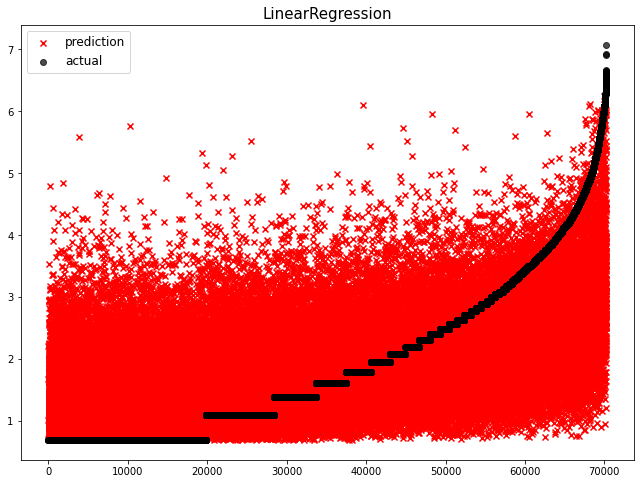

              model       mse
0  LinearRegression  1.234055


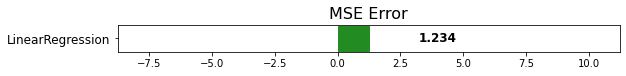

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
pred = linear_reg.predict(X_test)
mse_eval('LinearRegression', pred, y_test)

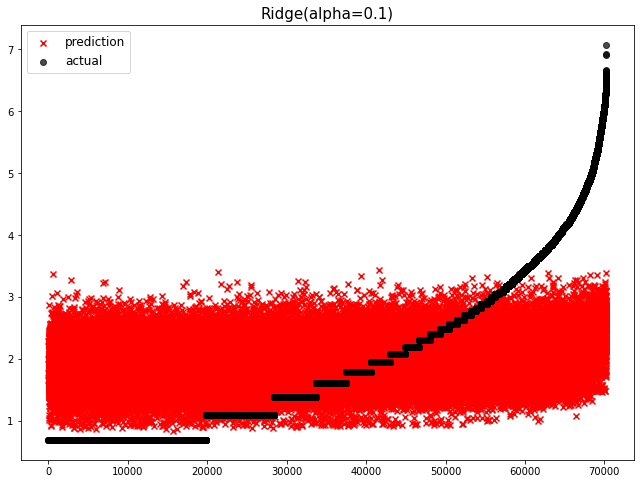

              model       mse
0  Ridge(alpha=0.1)  1.494773
1  LinearRegression  1.234055


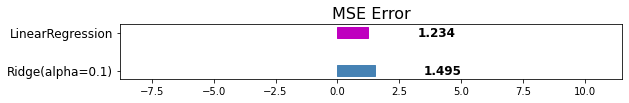

In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
mse_eval('Ridge(alpha=0.1)', pred, y_test)

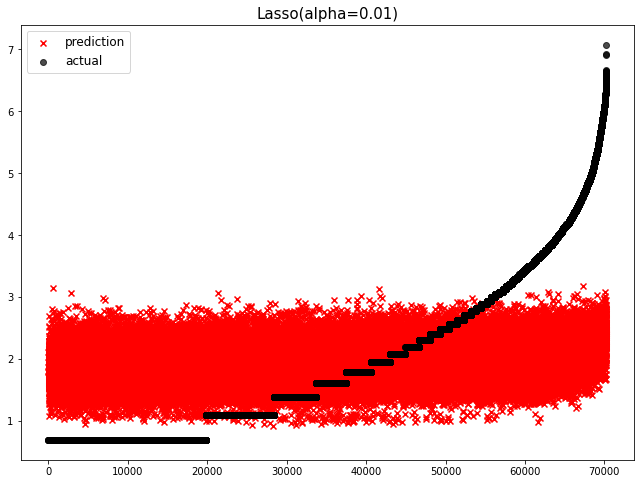

               model       mse
0  Lasso(alpha=0.01)  1.506729
1   Ridge(alpha=0.1)  1.494773
2   LinearRegression  1.494771


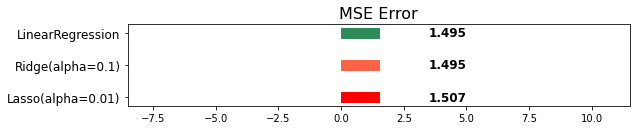

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
pred = lasso.predict(X_test)
mse_eval('Lasso(alpha=0.01)', pred, y_test)

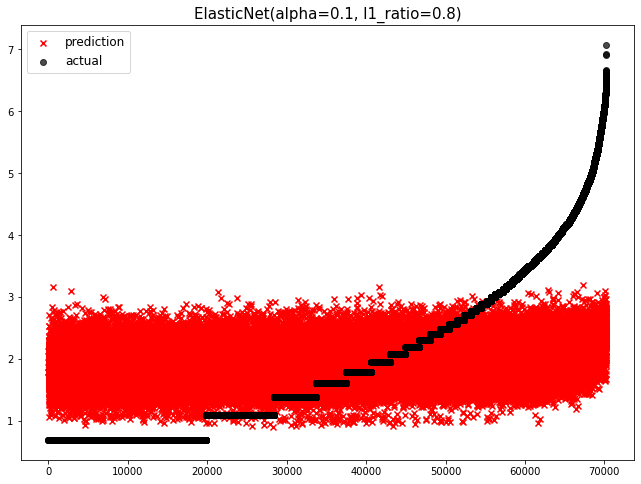

                                 model       mse
0                    Lasso(alpha=0.01)  1.506729
1  ElasticNet(alpha=0.1, l1_ratio=0.8)  1.505868
2                     Ridge(alpha=0.1)  1.494773
3                     LinearRegression  1.494771


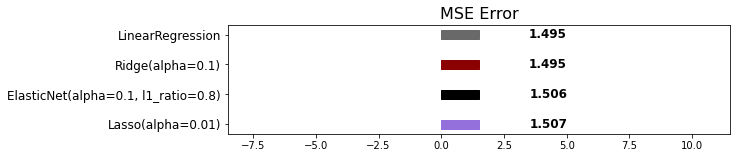

In [ ]:
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.8)
elasticnet.fit(X_train, y_train)
pred = elasticnet.predict(X_test)
mse_eval('ElasticNet(alpha=0.1, l1_ratio=0.8)', pred, y_test)    

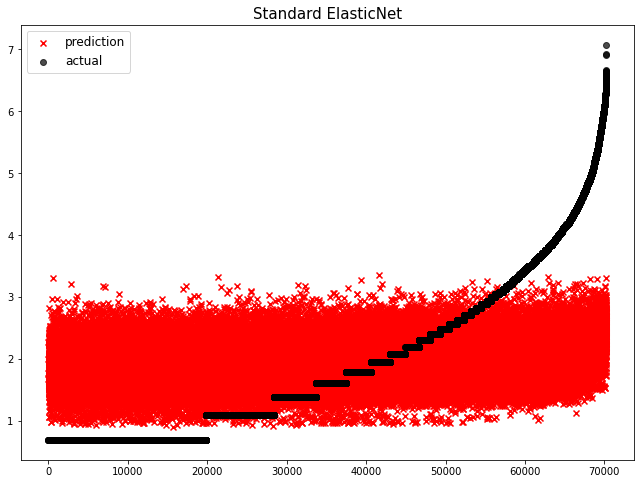

                                 model       mse
0                    Lasso(alpha=0.01)  1.506729
1  ElasticNet(alpha=0.1, l1_ratio=0.8)  1.505868
2                  Standard ElasticNet  1.494965
3                     Ridge(alpha=0.1)  1.494773
4                     LinearRegression  1.494771


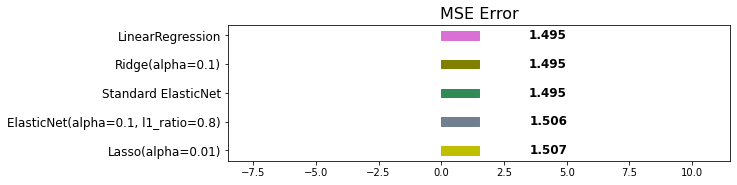

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.01, l1_ratio=0.8)
)
elasticnet_pipeline.fit(X_train, y_train)
elasticnet_pred = elasticnet_pipeline.predict(X_test)
mse_eval('Standard ElasticNet', elasticnet_pred, y_test)

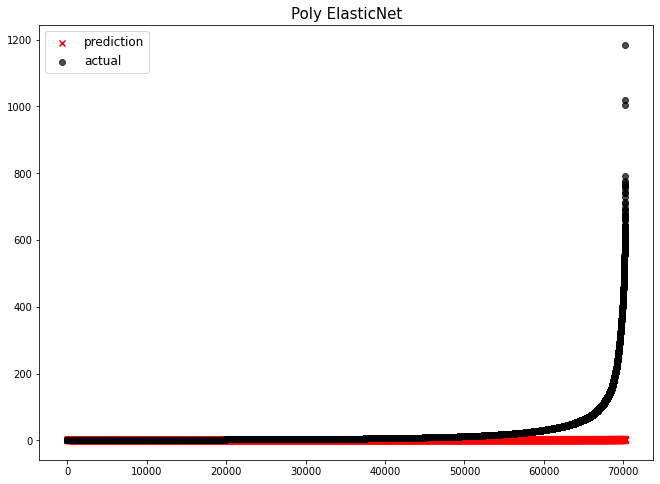

             model          mse
0  Poly ElasticNet  3319.342140
1  Voting Ensemble  3072.583603


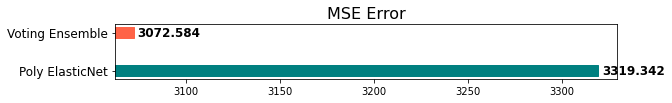

In [ ]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
poly_pipeline.fit(X_train, y_train)
poly_pred = poly_pipeline.predict(X_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

In [ ]:
poly_pred=np.e**poly_pred
max(poly_pred)

1.549977086441507e+23

In [ ]:
poly_pred

array([1.76445763, 1.64622033, 1.85768919, ..., 1.94138938, 2.09307173,
       1.63506956])

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet_pipeline', elasticnet_pipeline), 
    ('poly_pipeline', poly_pipeline)
]

In [ ]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [ ]:
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('linear_reg',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('ridge',
                             Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('lasso',
                             Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=Fals...
                                      steps=[('polynomialfeatures',
                                              PolynomialFeatures(degree=2,
                                                                 include_bias=False,
                                  

In [ ]:
voting_pred = voting_regressor.predict(X_test)

In [ ]:
voting_pred=np.e**voting_pred
# y_test=np.e**y_test

In [ ]:
max(voting_pred)

32.233251913985356

In [ ]:
max(y_test)

1184.999999999999

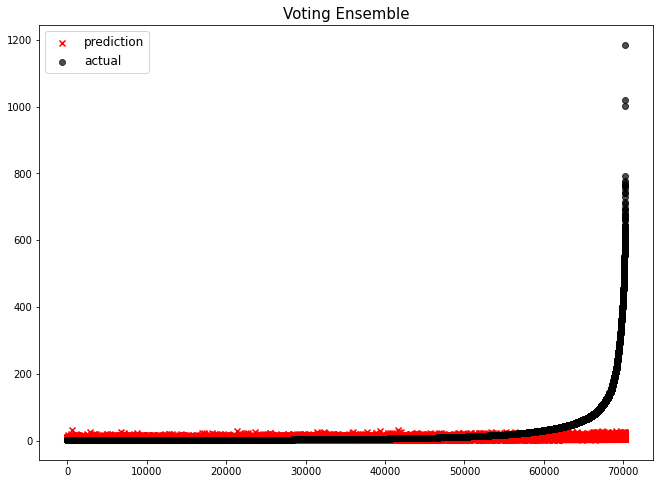

             model          mse
0  Voting Ensemble  3072.583603


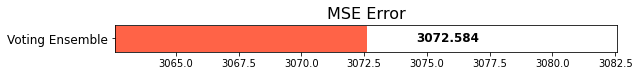

In [ ]:
mse_eval('Voting Ensemble', voting_pred, y_test)

In [ ]:
params = {
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8], 
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],
}
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
clf = RandomizedSearchCV(LGBMRegressor(), params, random_state=42, cv=3, n_iter=25, scoring='neg_mean_squared_error')

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.best_score_

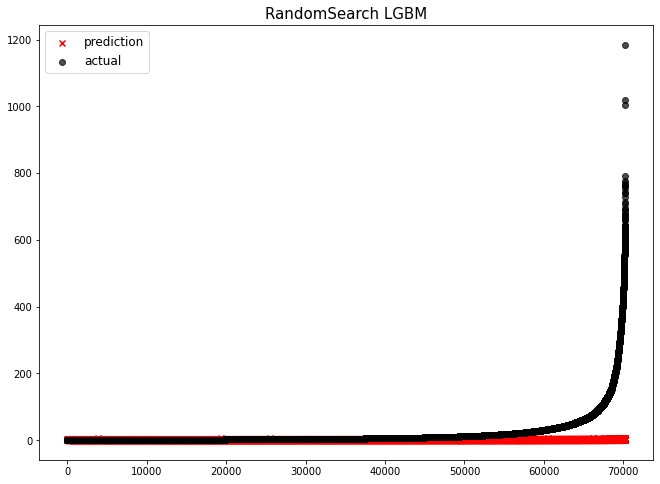

               model          mse
0    Poly ElasticNet  3319.342140
1  RandomSearch LGBM  3305.237276
2    Voting Ensemble  3072.583603


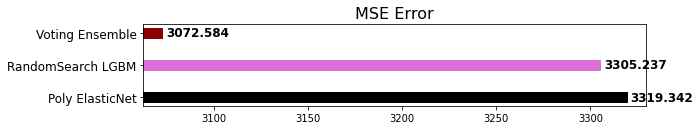

In [ ]:
lgbm_best = LGBMRegressor(n_estimators=2000, subsample=0.8, max_depth=7, learning_rate=0.01, colsample_bytree=0.8)
lgbm_best.fit(X_train, y_train)
lgbm_best_pred = lgbm_best.predict(X_test)
mse_eval('RandomSearch LGBM', lgbm_best_pred, y_test)